# **Lab 2: Brain Tumor MRI Feature Extraction**

- Reece Iriye: 48255107
- Eileen Garcia: 48241821
- Trevor Dohm: 48376059

## **0: Imports**

In [4]:
# Import Statements

# Data Manipulation
import numpy as np
import pandas as pd
import glob
import os

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Manipulation
from PIL import Image, ImageEnhance
import cv2

# Machine Learning
import torch
from torch import Tensor
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import (
    DataLoader, 
    TensorDataset, 
    random_split,
    Dataset,
)

# Other
import sys
import gc
from typing import List, Dict, Union
import warnings
warnings.filterwarnings('ignore')

## **1: Business & Data Understanding**

## **2: Data Preparation**

In [3]:
# Reload Information (Same As Before)

# Load Train / Test Data (Set IMG_SIZE = 256, Can Be <= 512)
trainDataMRI: str = 'Dataset/Training/'
testDataMRI: str = 'Dataset/Testing/'
IMG_SIZE: int = 256

# Label Encoding (0, 1, 2, 3)
labels: List[str] = ['glioma', 'meningioma', 'notumor', 'pituitary']
label_indexes: Dict[str, int] = {
    label: i 
    for i, label in enumerate(labels)
}

# Empty Lists For Data
train_paths: List[np.ndarray] = []  # train_paths: List Of Numpy Arrays Specifying Training Data
train_labels: List[int] = []        # train_labels: List Of Integers (Encoded Labels - 0, 1, 2, 3)
test_paths: List[np.ndarray] = []   # test_paths: List Of Numpy Arrays Specifying Testing Data
test_labels: List[int] = []         # test_labels: List Of Integers (Encoded Labels - 0, 1, 2, 3)

# Load Training Data
for label in labels:
    for img_file in glob.glob(trainDataMRI + f'/{label}/*.jpg'):

        # Loads Grayscale (Remove ',0' For Color)
        img: np.ndarray = cv2.imread(img_file, 0)

        # Image Resizing (Faster Load Time For Smaller IMG_SIZE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 

        # Normalize Pixel Values
        img = img.astype(np.float32) / 255.0 

        # Append To Lists
        train_paths.append(img)
        train_labels.append(label_indexes[label])

# Load Testing Data
for label in labels:
    for img_file in glob.glob(testDataMRI + f'/{label}/*.jpg'):

        # Loads Grayscale (Remove ',0' For Color)
        img: np.ndarray = cv2.imread(img_file, 0) 

        # Image Resizing (Faster Load Time For Smaller IMG_SIZE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 

        # Normalize Pixel Values
        img = img.astype(np.float32) / 255.0 

        # Append To Lists
        test_paths.append(img)
        test_labels.append(label_indexes[label])  

# Converting Lists To Numpy Arrays
trainPaths: np.ndarray = np.array(train_paths)
trainLabels: np.ndarray = np.array(train_labels)
testPaths: np.ndarray = np.array(test_paths)
testLabels: np.ndarray = np.array(test_labels)

# Resize Data (Linearize Images -> 1D Image Features Table, Row = Image)
trainPaths = trainPaths.reshape(trainPaths.shape[0], -1)
testPaths = testPaths.reshape(testPaths.shape[0], -1)

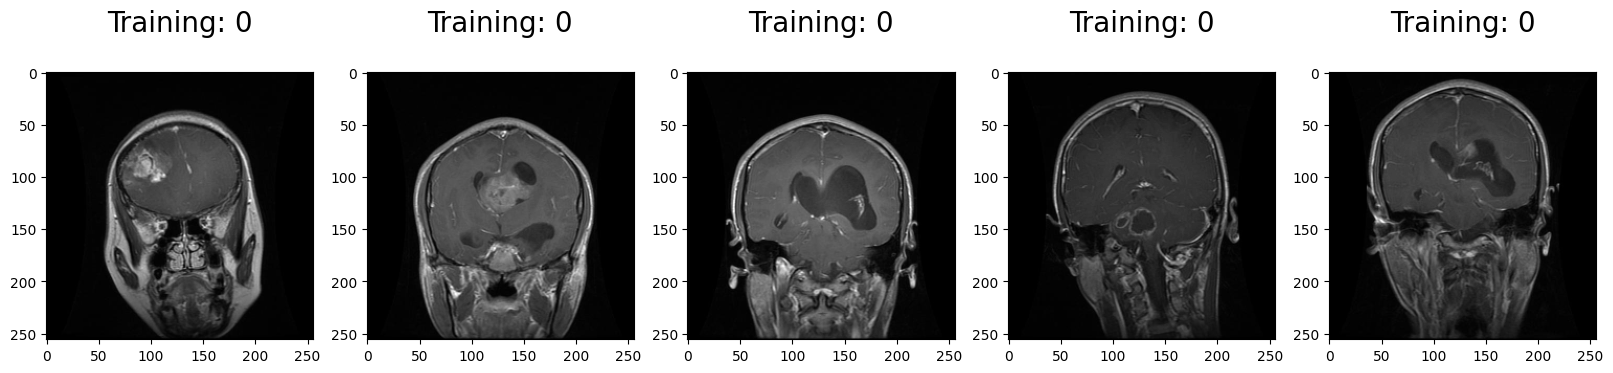

In [4]:
# Display Some Images From trainPaths
plt.figure(figsize = (20, 4))
for index, (image, label) in enumerate(zip(trainPaths[0:5], trainLabels[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (IMG_SIZE, IMG_SIZE)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)
plt.show()

## **3: Data Reduction**

### **3.1: Dimensionality Reduction with Principal Component Analysis**

### **3.2: Dimensionality with Randomized Principal Component Analysis**

### **3.3: Compare PCA and Randomized PCA**

### **3.4: Feature Extraction using ResNet**

For feature extraction, we decided to use a PyTorch implementation of the <a href="https://www.run.ai/guides/deep-learning-for-computer-vision/pytorch-resnet">Residual Network (ResNet)</a> architecture.  

In [5]:
# Instantiate the ResNet50 model
resnet50: models.ResNet = models.resnet50(pretrained = True)

cuda:0


In [6]:
%%time
# 1. Prepare the ResNet50 model for transfer learning
# 
# This replaces the last fully connected layer (originally trained for 
# the 1000-class ImageNet dataset) with a new fully connected layer that matches the 
# number of classes in your MRI dataset. Since this layer is newly initialized, it 
# contains random weights and will be trained from scratch, while the other layers 
# contain pre-trained weights from ImageNet.
NUM_CLASSES: int = len(labels)
resnet50.fc: torch.nn.Module = (
    torch.nn.Linear(resnet50.fc.in_features, NUM_CLASSES)
)

# If CUDA (NVIDIA GPU acceleration) is available, use it. Otherwise, use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50.to(device)  # Send the model to the selected device 

# 2. Prepare datasets for PyTorch
# Convert the loaded MRI images (numpy arrays) to PyTorch tensors
# Convert grayscale images to RGB format by repeating the single channel three times
train_tensors: Tensor = (
    torch.tensor(train_paths)
    .float()
    .view(-1, 1, IMG_SIZE, IMG_SIZE)
    .repeat(1, 3, 1, 1)  # GRAYSCALE IMAGE TO RGB FORMAT FOR torch.models 
)
test_tensors: Tensor = (
    torch.tensor(test_paths)
    .float()
    .view(-1, 1, IMG_SIZE, IMG_SIZE)
    .repeat(1, 3, 1, 1)  # GRAYSCALE IMAGE TO RGB FORMAT FOR torch.models
)

# Convert the image labels into tensor format for PyTorch
train_labels: Tensor = torch.tensor(train_labels).long()
test_labels: Tensor = torch.tensor(test_labels).long()

# Create PyTorch datasets using the image tensors and their corresponding labels
train_dataset: Dataset = TensorDataset(train_tensors, train_labels)
test_dataset: Dataset = TensorDataset(test_tensors, test_labels)

# Define data loaders to efficiently load image batches during training/testing
BATCH_SIZE: int = 32
train_loader: DataLoader = (
    DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True,  # Shuffling helps in better model generalization
    )
)
test_loader: DataLoader = (
    DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, # No need to shuffle test data
    )
)

# 3. Train the model
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.001)

# Training loop (THIS LOOP WAS GENERATED BY CHATGPT)
NUM_EPOCHS: int = 10
for epoch in range(NUM_EPOCHS):
    resnet50.train()  # Set the model to training mode
    train_loss: float = 0.0  # Initialize training loss
    
    # For each batch of images and labels
    for images, labels in train_loader:
        images: Tensor = images.to(device)  # Send data to the device (GPU/CPU)
        labels: Tensor = labels.to(device)
        
        optimizer.zero_grad()  # Zero out any previous gradients
        outputs: Tensor = resnet50(images)  # Forward pass: Get model predictions
        loss: Tensor = criterion(outputs, labels)  # Compute the loss for this batch
        loss.backward()  # Backward pass: compute the gradient of the loss w.r.t. model parameters
        optimizer.step()  # Update the model's weights
        
        train_loss += loss.item()  # Accumulate the training loss

    # Print average training loss for this epoch        
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} - Training loss: {train_loss/len(train_loader)}")

# 4. Evaluate the model
resnet50.eval()  # Set the model to evaluation mode
correct: int = 0  # Count of correct predictions
total: int = 0   # Total number of images processed

# We won't update the model, so we tell PyTorch not to compute gradients
with torch.no_grad():
    for images, labels in test_loader:
        images: Tensor = images.to(device)
        labels: Tensor = labels.to(device)
        outputs: Tensor = resnet50(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the class with highest predicted probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # Count correct predictions

# Print the accuracy of the model on the test data
print(f"Accuracy of the model on test images: {100 * correct / total}%")

cuda:0
Epoch 1/10 - Training loss: 0.4171058736616673
Epoch 2/10 - Training loss: 0.24048794202464918
Epoch 3/10 - Training loss: 0.17606037150673026
Epoch 4/10 - Training loss: 0.1445209681974755
Epoch 5/10 - Training loss: 0.11966687487308249
Epoch 6/10 - Training loss: 0.10562789063203518
Epoch 7/10 - Training loss: 0.0759450301941609
Epoch 8/10 - Training loss: 0.07359373944358868
Epoch 9/10 - Training loss: 0.07474656748408504
Epoch 10/10 - Training loss: 0.07426049515563349
Accuracy of the model on test images: 96.5675057208238%
CPU times: total: 37min 19s
Wall time: 10min 44s


### **3.5: ResNET Performance for Prediction Task**

## **4: Exceptional Work**

We have chosen to implement Meta DinoV2, a series of base models that generate universal features applicable for various image-level visual tasks. These tasks include image classification, instance retrieval, and video comprehension. Moreover, these features also facilitate pixel-level visual tasks like depth estimation and semantic segmentation.

We carry out Dense Matching that boasts state-of-the-art results, and impressive generalization in evaluating depth from a single image. We also conduct Depth Estimation, which utilizes DinoV2 patch features for consistently mapping all portions of an image without supervision. 

Subsequently, we classify the results using a pre-trained Vision Transformer (ViT) with an additional linear probe for our classification task. To ensure efficient operation, we initially free up memory in the GPU by killing the existing kernel before executing the following code. This helps to prevent system crashing and enables smooth loading of the Vision Transformer.

Disclaimer: All references and resources utilized can be found at the end of this notebook. These include numerous sources such as the official DinoV2 repository and various Medium articles which feature the implementation of these models which we have taken inspiration from.

In [25]:
# Crash Python Kernel (Need More VRAM)
torch.cuda.empty_cache()
gc.collect()
os.kill(os.getpid(), 9)

: 

In [1]:
# Import Statements

# Data Manipulation
import numpy as np
import pandas as pd
import glob
import os
import math
import itertools
from functools import partial
from tqdm.notebook import tqdm

# Data Visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Image Manipulation
from PIL import Image, ImageEnhance
import cv2

# Machine Learning
import mmcv
from mmengine.runner import load_checkpoint
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as functional
import torch.backends.cudnn as cudnn
from torch.utils.data import (
    DataLoader, 
    TensorDataset, 
    random_split,
    Dataset,
)

# Other
import sys
import gc
import urllib
import time
import copy
import random
import json
import requests
from typing import List, Dict, Union
import warnings
warnings.filterwarnings('ignore')

In the initial steps of our project, we add the DinoV2 repository to our current path and import the required libraries from this repository. Following this, we deploy a pre-trained Vision Transformer (ViT) model. For operations pertaining to Dense Matching and Depth Estimation, we use the giant model (4.2 Gigabytes) to maximize the effectiveness of these tasks. Conversely, for users with resource limitations, a smaller model is offered. During the classification task, we make use of the base model, as it operates optimally for this process (and I don't hate my laptop). Note that in this section, we have also configured the device for GPU usage to expedite processing. We then reload the dataset and specify the number of classes for our classification task. Since we've already explained this process, we'll proceed without further explanation.

In [2]:
# Specify DinoV2 Local Path (Different For Everyone)
REPO_PATH = "../../dinov2/"
sys.path.append(REPO_PATH)

# DinoV2 Imports (Includes OpenMMLabs)
from dinov2.eval.depth.models import build_depther

In [3]:
# Choose Model: S (Small), B (Base), L (Large), G (Giant)
BACKBONE_SIZE = "giant" 

# Set Backbone Architecture (For Load)
backbone_archs = {"small": "vits14", "base": "vitb14", "large": "vitl14", "giant": "vitg14"} 
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

# Load Backbone Model, Check Evaluation Mode, Send To GPU
backbone_model = torch.hub.load(repo_or_dir = "facebookresearch/dinov2", model = backbone_name)
backbone_model.eval()
backbone_model.cuda()

# If CUDA (NVIDIA GPU Acceleration) Available, Use It. Otherwise, Use CPU.
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

Using cache found in C:\Users\trevo/.cache\torch\hub\facebookresearch_dinov2_main
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [4]:
# Reload Information (Same As Before)

# Load Train / Test Data (Set IMG_SIZE = 256, Can Be <= 512)
trainDataMRI: str = 'Dataset/Training/'
testDataMRI: str = 'Dataset/Testing/'
IMG_SIZE: int = 256

# Label Encoding (0, 1, 2, 3)
labels: List[str] = ['glioma', 'meningioma', 'notumor', 'pituitary']
label_indexes: Dict[str, int] = {
    label: i 
    for i, label in enumerate(labels)
}

# Empty Lists For Data
train_paths: List[np.ndarray] = []  # train_paths: List Of Numpy Arrays Specifying Training Data
train_labels: List[int] = []        # train_labels: List Of Integers (Encoded Labels - 0, 1, 2, 3)
test_paths: List[np.ndarray] = []   # test_paths: List Of Numpy Arrays Specifying Testing Data
test_labels: List[int] = []         # test_labels: List Of Integers (Encoded Labels - 0, 1, 2, 3)

# Load Training Data
for label in labels:
    for img_file in glob.glob(trainDataMRI + f'/{label}/*.jpg'):

        # Loads Grayscale (Remove ',0' For Color)
        img: np.ndarray = cv2.imread(img_file, 0)

        # Image Resizing (Faster Load Time For Smaller IMG_SIZE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 

        # Normalize Pixel Values
        img = img.astype(np.float32) / 255.0 

        # Append To Lists
        train_paths.append(img)
        train_labels.append(label_indexes[label])

# Load Testing Data
for label in labels:
    for img_file in glob.glob(testDataMRI + f'/{label}/*.jpg'):

        # Loads Grayscale (Remove ',0' For Color)
        img: np.ndarray = cv2.imread(img_file, 0) 

        # Image Resizing (Faster Load Time For Smaller IMG_SIZE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 

        # Normalize Pixel Values
        img = img.astype(np.float32) / 255.0 

        # Append To Lists
        test_paths.append(img)
        test_labels.append(label_indexes[label])  

# Converting Lists To Numpy Arrays
trainPaths: np.ndarray = np.array(train_paths)
trainLabels: np.ndarray = np.array(train_labels)
testPaths: np.ndarray = np.array(test_paths)
testLabels: np.ndarray = np.array(test_labels)

# Resize Data (Linearize Images -> 1D Image Features Table, Row = Image)
trainPaths = trainPaths.reshape(trainPaths.shape[0], -1)
testPaths = testPaths.reshape(testPaths.shape[0], -1)

In the following section, we first create the necessary transforms that we will need. The f

After that, we get 
Send the batch of 4(or any) to the model and extract the features.

Note we get the normalization and center crop parameters from the paper.

In [5]:
# Transform Data (Convert To Tensors - 256 Standard Size, 224 Center Crop)
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224),
                                transforms.ToTensor(), transforms.Normalize(
                                mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

# Add Transforms To Load Images (518 * 518 Resize As Shown In The Paper)
transform1 = transforms.Compose([transforms.Resize(512), transforms.CenterCrop(518), # Should Be Multiple Of Model Patch Size              
                                transforms.ToTensor(), transforms.Normalize(mean = 0.5, std = 0.2)]) # Normalization

In [52]:
# Grab Patch Size From Backbone Model (Patch Size = 14)
patch_size = backbone_model.patch_size

# Perform Integer Division With Patch Size (520 / 14 = 37)
patch_h  = 520 // patch_size
patch_w  = 520 // patch_size

# Choose Feature Dimension (Depends On Backbone Size)
feat_dims = {"small": 384, "base": 768, "large": 1024, "giant": 1536} 
feat_dim = feat_dims[BACKBONE_SIZE]

# Create Empty List For Features
total_features  = []

# Keep Same Images For Later
used_images = []

# Loop Through Labels (No Gradient Updating)
with torch.no_grad():
    for label in labels:
        for img_file in glob.glob('Dataset/Training/' + f'/{label}/*.jpg'):

            # Open Image File, Convert To RGB
            img = Image.open(img_file).convert('RGB')

            # Append Image To List
            used_images.append(cv2.resize(cv2.imread(img_file, 0), (IMG_SIZE, IMG_SIZE)).astype(np.float32) / 255.0)

            # Transform (Keeping Data Same), Force Data Onto Same Device
            img_t = transform1(img).to(device)

            # Forward Pass (Get Features)
            features_dict = backbone_model.forward_features(img_t.unsqueeze(0))
            features = features_dict['x_norm_patchtokens']
            total_features.append(features)

            # Only Get One Of Each Label
            break

# Concat Features Together
total_features = torch.cat(total_features, dim = 0)
total_features.shape

# Convert To Numpy Array
used_images = np.array(used_images)

We perform Visualization of the first PCA components. We compute a PCA between the patches of the
images from the same column (a, b, c and d) and show their first 3 components. Each component is matched
to a different color channel. Same parts are matched between related images despite changes of pose, style
or even objects. Background is removed by thresholding the first PCA component.

We do this as 

1. Feature Visualization:
Like Mentioned in paper, I have used the features from Images using 2 step-PCA to visualize in a fashion showed in paper. The above visualization is the result of it.


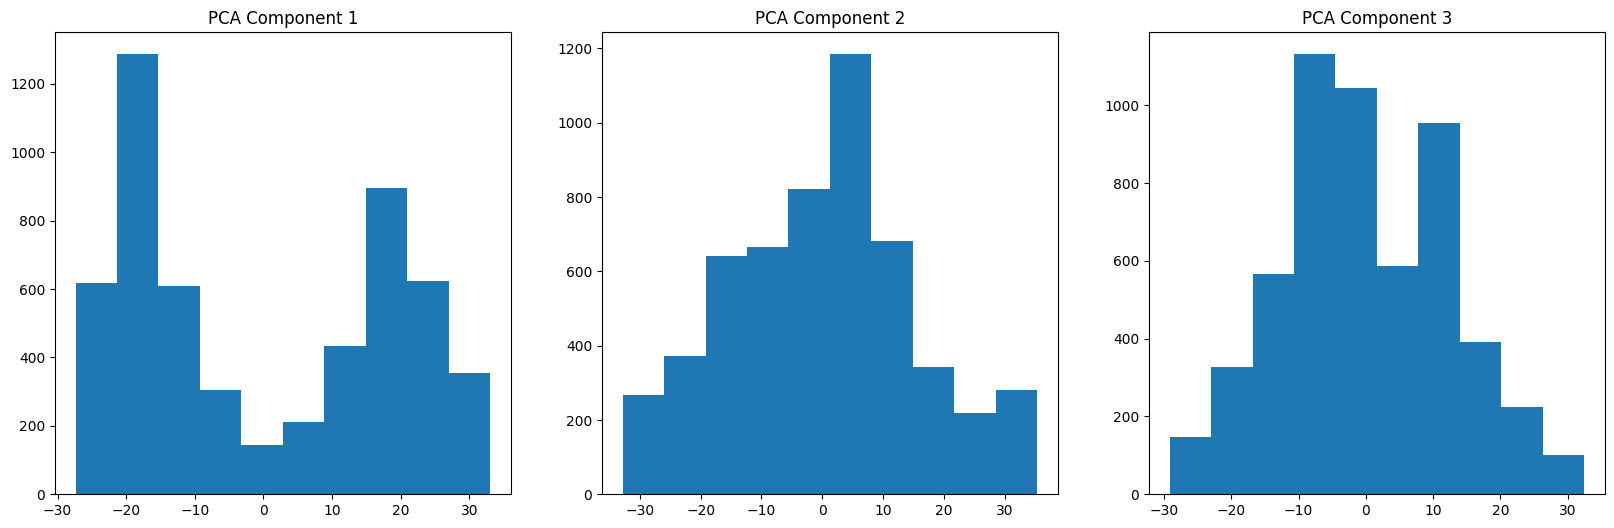

In [33]:
# First PCA => Seperate Background, Sklearn Expects 2D Array (4 * H * W, 1024)
total_features = total_features.reshape(4 * patch_h * patch_w, feat_dim)

# Perform PCA With Three Components - As Mentioned In Paper
pca = PCA(n_components = 3)

# Copy CUDA Tensor To CPU Memory
cpu_tensor = total_features.cpu()

# Convert CPU Tensor To NumPy Array
numpy_array = cpu_tensor.numpy()

# Fit PCA Model To Data, Transform Data
pca.fit(numpy_array)
pca_features = pca.transform(numpy_array)

# Visualize PCA Components For Finding A Proper Threshold - 3 Histograms For 3 Components
plt.figure(figsize = (20, 6))

# Plot PCA Component 1
plt.subplot(1, 3, 1)
plt.hist(pca_features[:, 0])
plt.title("PCA Component 1")

# Plot PCA Component 2
plt.subplot(1, 3, 2)
plt.hist(pca_features[:, 1])
plt.title("PCA Component 2")

# Plot PCA Component 3
plt.subplot(1, 3, 3)
plt.hist(pca_features[:, 2])
plt.title("PCA Component 3")

# Show, Close Plot
plt.show()
plt.close()

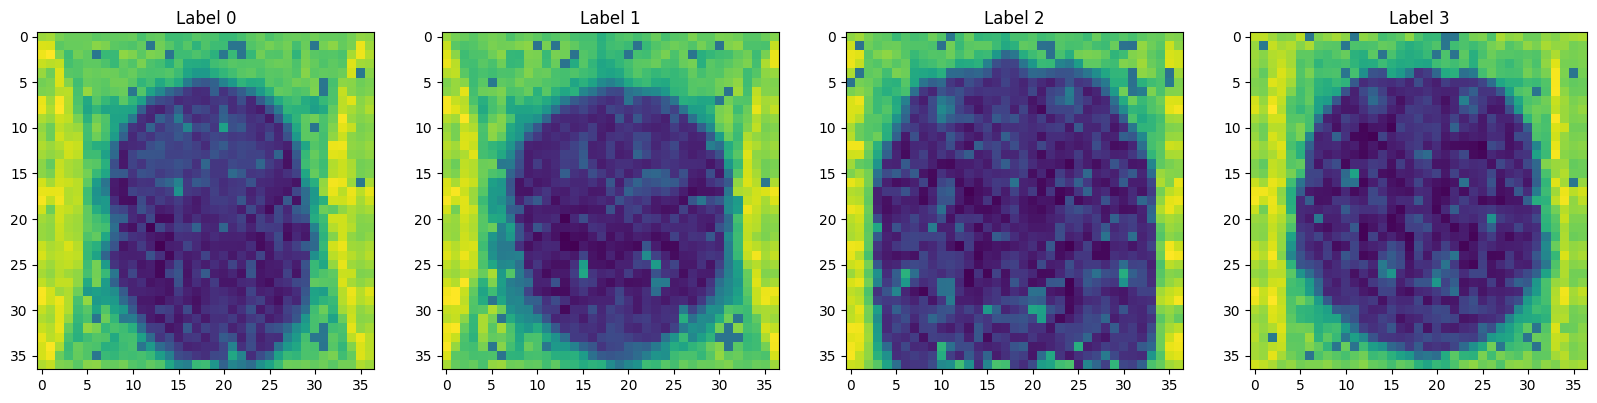

In [34]:
# Min Max Scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / (pca_features[:, 0].max() - pca_features[:, 0].min())

# 2 - Step PCA (As Mentioned In Paper)
plt.figure(figsize = (20, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"Label {i}")
    plt.imshow(pca_features[i * patch_h * patch_w : (i + 1) * patch_h * patch_w, 0].reshape(patch_h, patch_w))
plt.show()

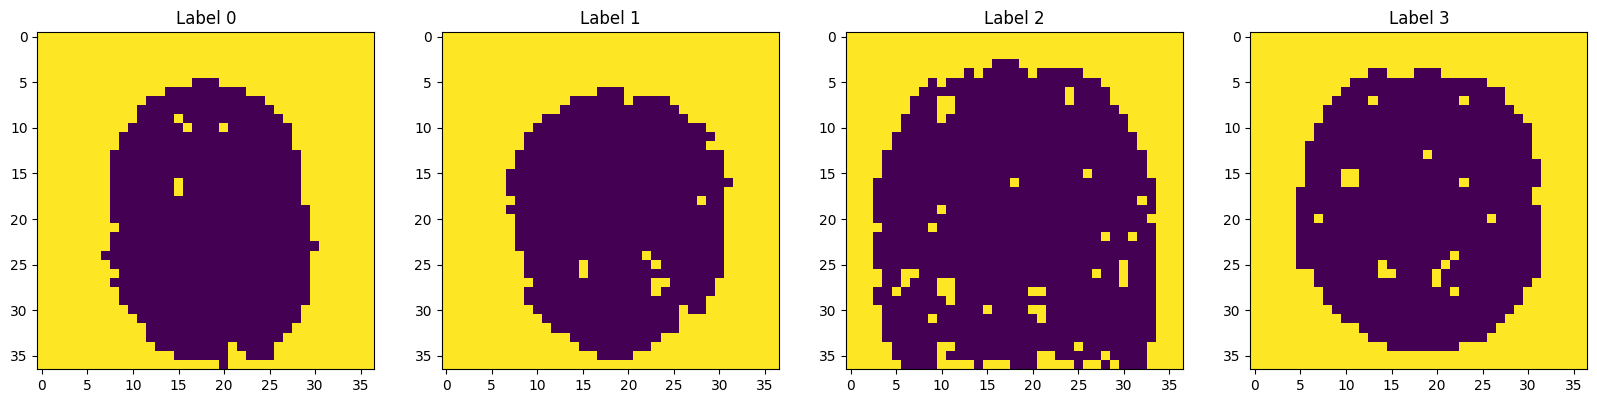

In [36]:
# Segment / Separate Background And Foreground Using The First Component (Take First Component > 0.35, Bitwise Flip)
pca_features_bg = pca_features[:, 0] > 0.35
pca_features_fg = ~pca_features_bg

# Plot PCA Features Background
plt.figure(figsize = (20, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"Label {i}")
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i + 1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()

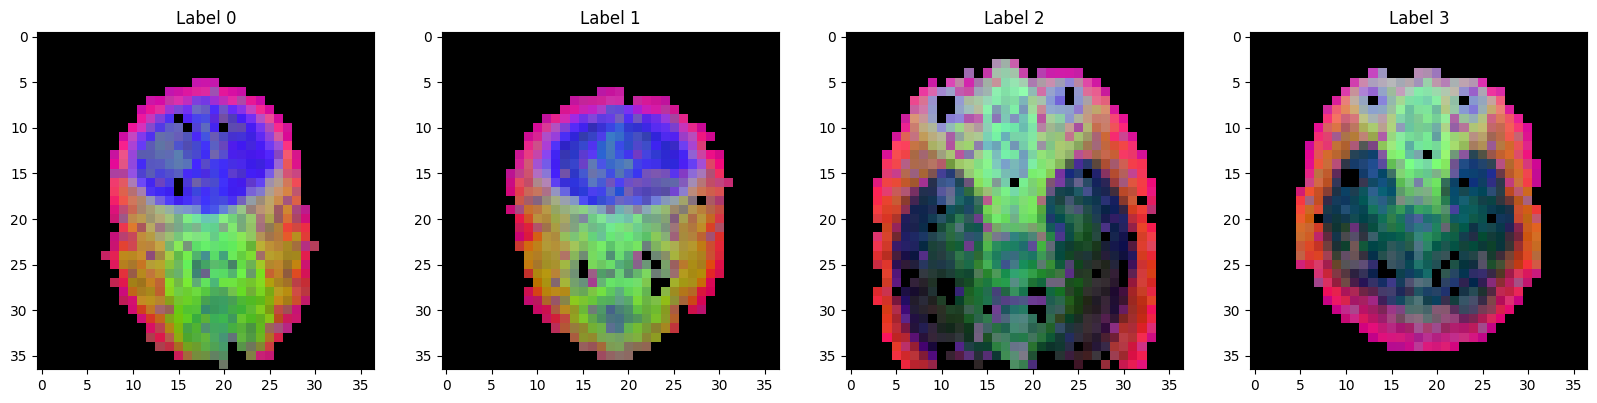

In [37]:
# 2nd PCA For Only Foreground Patches
pca.fit(numpy_array[pca_features_fg]) 
pca_features_left = pca.transform(numpy_array[pca_features_fg])

# Min Max Scale
for i in range(3):
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

# Copying PCA Features
pca_features_rgb = pca_features.copy()

# Black Background (For Better Contrast)
pca_features_rgb[pca_features_bg] = 0

# New Scaled Foreground Features
pca_features_rgb[pca_features_fg] = pca_features_left

# Reshaping To NumPy Image Format
pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)

# Plot PCA Features RGB
plt.figure(figsize = (20, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"Label {i}")
    plt.imshow(pca_features_rgb[i])
plt.show()

we eliminate the background and again apply a second step PCA on foreground image features only. ^^^

In [38]:
# Taken From DinoV2 Repository For Depth Mapping

# CenterPadding Adds Padding To Input Tensor
class CenterPadding(torch.nn.Module):

    # Initialize Multiple
    def __init__(self, multiple):
        super().__init__()
        self.multiple = multiple

    # Calculate Padding Needed On Both Sides To Obtain Desired Size
    def _get_pad(self, size):
        new_size = math.ceil(size / self.multiple) * self.multiple
        pad_size = new_size - size
        pad_size_left = pad_size // 2
        pad_size_right = pad_size - pad_size_left
        return pad_size_left, pad_size_right

    # Apply Padding To Input Tensor
    @torch.inference_mode()
    def forward(self, x):
        pads = list(itertools.chain.from_iterable(self._get_pad(m) for m in x.shape[:1:-1]))
        output = functional.pad(x, pads)
        return output

# Create Depther Model - Based On Configurations Passed Beforehand
# backbone_mode: Pretrained Base Model For Feature Extraction
# backbone_size: Size Of Backbones
# head_type: Type Of Model Head (Classifier, Regressor, Etc.)
def create_depther(cfg, backbone_model, backbone_size, head_type):

    # Extract Train / Test Configurations
    train_cfg = cfg.get("train_cfg")
    test_cfg = cfg.get("test_cfg")
    depther = build_depther(cfg.model, train_cfg = train_cfg, test_cfg = test_cfg)

    # Depth Estimation Model Built Using Provided Model Configurations
    # Forward Function Overridden With get_intermediate_layers() - 
    # Gets Outputs From Intermediate Layers Of Backbone During Forward Pass
    depther.backbone.forward = partial(
        backbone_model.get_intermediate_layers,
        n = cfg.model.backbone.out_indices,
        reshape = True,
        return_class_token = cfg.model.backbone.output_cls_token,
        norm = cfg.model.backbone.final_norm,
    )

    # If Backbone Model Has Patch Size, Register Forward Pre Hook
    if hasattr(backbone_model, "patch_size"):
        depther.backbone.register_forward_pre_hook(lambda _, x: CenterPadding(backbone_model.patch_size)(x[0]))

    # Return Depth Estimator Model
    return depther


In [39]:
# Load Config From URL
def load_config_from_url(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode()

# Choose Dataset And Head Type
HEAD_DATASET = "nyu"    # ("nyu", "kitti")
HEAD_TYPE = "dpt"       # ("linear", "linear4", "dpt")

# Load Config From URL
DINOV2_BASE_URL = "https://dl.fbaipublicfiles.com/dinov2"
head_config_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_config.py"
head_checkpoint_url = f"{DINOV2_BASE_URL}/{backbone_name}/{backbone_name}_{HEAD_DATASET}_{HEAD_TYPE}_head.pth"

# Load Config From URL, Convert To String, Load Config From String
cfg_str = load_config_from_url(head_config_url)
cfg = mmcv.Config.fromstring(cfg_str, file_format = ".py")

# Create Depther Model
model = create_depther(
    cfg,
    backbone_model = backbone_model,
    backbone_size = BACKBONE_SIZE,
    head_type = HEAD_TYPE,
)

# Load Checkpoint From URL
load_checkpoint(model, head_checkpoint_url, map_location = "cpu")
model.eval()
model.cuda()

Loads checkpoint by http backend from path: https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_nyu_dpt_head.pth


DepthEncoderDecoder(
  (backbone): DinoVisionTransformer()
  (decode_head): DPTHead(
    align_corners=False
    (loss_decode): ModuleList(
      (0): SigLoss()
      (1): GradientLoss()
    )
    (conv_depth): HeadDepth(
      (head): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Interpolate()
        (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (relu): ReLU()
    (sigmoid): Sigmoid()
    (reassemble_blocks): ReassembleBlocks(
      (projects): ModuleList(
        (0): ConvModule(
          (conv): Conv2d(1536, 192, kernel_size=(1, 1), stride=(1, 1))
        )
        (1): ConvModule(
          (conv): Conv2d(1536, 384, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvModule(
          (conv): Conv2d(1536, 768, kernel_size=(1, 1), stride=(1, 1))
        )
        (3): ConvModule(
        

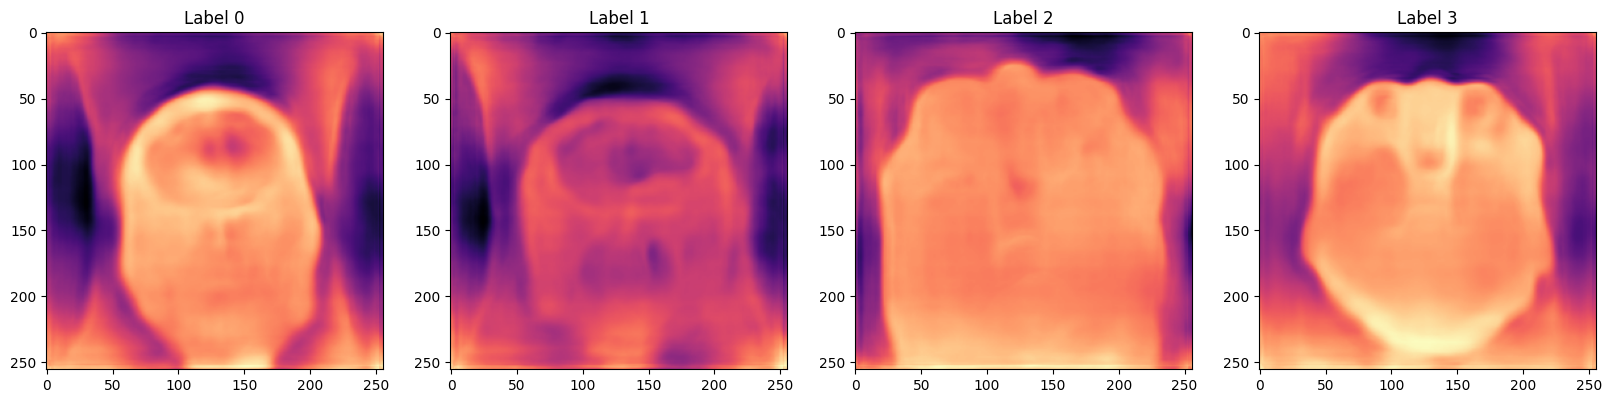

In [53]:
def make_depth_transform() -> transforms.Compose:
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # Repeat the single channel to make it 3-channel
        lambda x: 255.0 * x, # scale by 255 
        transforms.Normalize(
            mean=(123.675, 116.28, 103.53),
            std=(58.395, 57.12, 57.375),
        ),
    ])


def render_depth(values, colormap_name="magma_r") -> Image:
    min_value, max_value = values.min(), values.max()
    normalized_values = (values - min_value) / (max_value - min_value)

    colormap = matplotlib.colormaps[colormap_name]
    colors = colormap(normalized_values, bytes=True) # ((1)xhxwx4)
    colors = colors[:, :, :3] # Discard alpha component
    return Image.fromarray(colors)

transform = make_depth_transform()

# Plot PCA Features RGB
plt.figure(figsize = (20, 6))
for i in range(4):
    transformed_image = transform(used_images[i])
    batch = transformed_image.unsqueeze(0).cuda() # Make a batch of one image

    with torch.inference_mode():
        result = model.whole_inference(batch, img_meta=None, rescale=True)

    depth_image = render_depth(result.squeeze().cpu())

    plt.subplot(1, 4, i + 1)
    plt.title(f"Label {i}")
    plt.imshow(depth_image)
plt.show()

2. Image Classification:
I also have used DinoV2 for Classification, and compared it with Resnets(might not be a fair comparision of transformers vs CNNs).

In [17]:
# Crash Python Kernel (Need More VRAM)
torch.cuda.empty_cache()
gc.collect()
os.kill(os.getpid(), 9)

: 

In [4]:
# Import Statements

# Data Manipulation
import numpy as np
import pandas as pd
import glob
import os
import math
import itertools
from functools import partial
from tqdm.notebook import tqdm

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Image Manipulation
from PIL import Image, ImageEnhance
import cv2

# Machine Learning
import optuna
import mmcv
from mmengine.runner import load_checkpoint
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as functional
import torch.backends.cudnn as cudnn
from torch.utils.data import (
    DataLoader, 
    TensorDataset, 
    random_split,
    Dataset,
)

# Other
import sys
import gc
import urllib
import time
import copy
import random
import json
import requests
from typing import List, Dict, Union
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Specify DinoV2 Local Path (Different For Everyone)
REPO_PATH = "../../dinov2/"
sys.path.append(REPO_PATH)

In [3]:
# Choose Model: S (Small), B (Base), L (Large), G (Giant)
BACKBONE_SIZE = "base" 

# Set Backbone Architecture (For Load)
backbone_archs = {"small": "vits14", "base": "vitb14", "large": "vitl14", "giant": "vitg14"} 
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

# Load Backbone Model, Check Evaluation Mode, Send To GPU
backbone_model = torch.hub.load(repo_or_dir = "facebookresearch/dinov2", model = backbone_name)

# If CUDA (NVIDIA GPU Acceleration) Available, Use It. Otherwise, Use CPU.
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

Using cache found in C:\Users\trevo/.cache\torch\hub\facebookresearch_dinov2_main
A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [4]:
# def set_seed(no):
#     torch.manual_seed(no)
#     random.seed(no)
#     np.random.seed(no)
#     os.environ['PYTHONHASHSEED'] = str()
#     torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.deterministic = True

# set_seed(100)

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Training': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Dataset/'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Testing']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size = 32, 
                                              shuffle = True,
                                              num_workers = 4) 
                                              for x in ['Training', 'Testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}
class_names = image_datasets['Training'].classes

In [6]:
# 384 For Small, 768 For Base, 1024 For Large, 1536 For Giant
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = backbone_model
        self.classifier = nn.Sequential(
            nn.Linear(768, 1024),
            nn.Dropout(0.5),
            nn.GELU(),
            nn.Linear(1024, 256),
            nn.Dropout(0.5),
            nn.GELU(),
            nn.Linear(256, 4)
        )
    
    def forward(self, x):
        x = self.transformer(x)
        # x = self.transformer.norm(x)
        x = self.classifier(x)        
        return x

In [11]:
model = DinoVisionTransformerClassifier()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 0.001)

study = optuna.create_study(direction = 'maximize')
study.optimize(model.forward, n_trials = 100)

In [12]:
for i,j in list(model.named_parameters())[:-2]:
    if "transformer" in i:
        j.requires_grad = False

In [13]:
NUM_EPOCHS: int = 5
for epoch in range(NUM_EPOCHS):

    running_loss = 0.0
    for i, data in enumerate(dataloaders["Training"], 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        # optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # print statistics
        running_loss += loss.item()
        # print(f'{loss}')
        if i % 50 == 49:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0

print('Training Complete! :)')

[1,    50] loss: 0.741
[1,   100] loss: 0.470
[1,   150] loss: 0.410
[2,    50] loss: 0.380
[2,   100] loss: 0.352
[2,   150] loss: 0.299
[3,    50] loss: 0.323
[3,   100] loss: 0.295
[3,   150] loss: 0.268
[4,    50] loss: 0.264
[4,   100] loss: 0.273
[4,   150] loss: 0.265
[5,    50] loss: 0.242
[5,   100] loss: 0.280
[5,   150] loss: 0.265
UwU Training Complete


In [15]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders["Testing"]:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to("cpu") == labels).sum().item()

print(f'Accuracy of the network on the {len(dataloaders["Testing"])*6} test images: {100.0 * correct // total} %')

Accuracy of the network on the 246 test images: 89.0 %



https://github.com/purnasai/Dino_V2
https://github.com/facebookresearch/dinov2
https://dinov2.metademolab.com/
https://arxiv.org/pdf/2304.07193.pdf

@misc{oquab2023dinov2,
  title={DINOv2: Learning Robust Visual Features without Supervision},
  author={Oquab, Maxime and Darcet, Timothée and Moutakanni, Theo and Vo, Huy V. and Szafraniec, Marc and Khalidov, Vasil and Fernandez, Pierre and Haziza, Daniel and Massa, Francisco and El-Nouby, Alaaeldin and Howes, Russell and Huang, Po-Yao and Xu, Hu and Sharma, Vasu and Li, Shang-Wen and Galuba, Wojciech and Rabbat, Mike and Assran, Mido and Ballas, Nicolas and Synnaeve, Gabriel and Misra, Ishan and Jegou, Herve and Mairal, Julien and Labatut, Patrick and Joulin, Armand and Bojanowski, Piotr},
  journal={arXiv:2304.07193},
  year={2023}
}

@inproceedings{optuna_2019,
    title={Optuna: A Next-generation Hyperparameter Optimization Framework},
    author={Akiba, Takuya and Sano, Shotaro and Yanase, Toshihiko and Ohta, Takeru and Koyama, Masanori},
    booktitle={Proceedings of the 25th {ACM} {SIGKDD} International Conference on Knowledge Discovery and Data Mining},
    year={2019}
}

In [21]:
# Choose Model: S (Small), B (Base), L (Large), G (Giant)
BACKBONE_SIZE = "base" 

# Set Backbone Architecture (For Load)
backbone_archs = {"small": "vits14", "base": "vitb14", "large": "vitl14", "giant": "vitg14"} 
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

# Load Backbone Model, Check Evaluation Mode, Send To GPU
backbone_model = torch.hub.load(repo_or_dir = "facebookresearch/dinov2", model = backbone_name)

# If CUDA (NVIDIA GPU Acceleration) Available, Use It. Otherwise, Use CPU.
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")



# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'Training': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'Dataset/'
image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Training', 'Testing']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size = 32, 
                                              shuffle = True,
                                              num_workers = 4) 
                                              for x in ['Training', 'Testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}
class_names = image_datasets['Training'].classes



# 384 For Small, 768 For Base, 1024 For Large, 1536 For Giant
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self, layers=[], dropouts=[]):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = backbone_model

        m = []
        layers = [768] + layers
        for l in range(0, len(layers)-1):
            m.append(nn.Linear(layers[l], layers[l+1]))
            m.append(nn.Dropout(dropouts[l]))
            m.append(nn.GELU())
        m.append(nn.Linear(layers[-1], 4))
        self.classifier = nn.Sequential(*m)
        # self.classifier = nn.Sequential(
        #     nn.Linear(768, 1024),
        #     nn.Dropout(0.5),
        #     nn.GELU(),
        #     nn.Linear(1024, 256),
        #     nn.Dropout(0.5),
        #     nn.GELU(),
        #     nn.Linear(256, 4)
        # )
    
    def forward(self, x):
        x = self.transformer(x)
        # x = self.transformer.norm(x)
        x = self.classifier(x)        
        return x




# Define a model for optuna to optimize
def create_model(trial):
    ### Suggested parameters of the model
    
    # Number of layers
    n_layers = trial.suggest_int("n_layers", 1, 2)
    
    # Number of nodes per layer and dropout rate per layer
    hidden_layer_nodes = []
    dropout_rates = []
    for i in range(0, n_layers):
        hidden_layer_nodes.append(trial.suggest_int(f"n_nodes_{i}", 32, 256))
        dropout_rates.append(trial.suggest_float(f"dropout_per{i}", 0.1, 0.5))
    
    # Optimizer
    #optimizer = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    # lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    # optimizer = "Adam"
        
        
    # Return the model
    return DinoVisionTransformerClassifier(hidden_layer_nodes, dropout_rates)

Using cache found in C:\Users\trevo/.cache\torch\hub\facebookresearch_dinov2_main


In [16]:
def train_loop(model):
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.AdamW(model.parameters(), lr = 0.001)
  NUM_EPOCHS: int = 2
  for epoch in range(NUM_EPOCHS):

      running_loss = 0.0
      for i, data in enumerate(dataloaders["Training"], 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # zero the parameter gradients
          # optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs.to(device))
          loss = criterion(outputs, labels.to(device))
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

          # print statistics
          running_loss += loss.item()
          # print(f'{loss}')
          if i % 50 == 49:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
              running_loss = 0.0

  print('UwU Training Complete')
  return model, loss

In [17]:
def test_loop(model):
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in dataloaders["Testing"]:
          images, labels = data
          # calculate outputs by running images through the network
          outputs = model(images.to(device))
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted.to("cpu") == labels).sum().item()

  print(f'Accuracy of the network on the {len(dataloaders["Testing"])*6} test images: {100.0 * correct // total} %')
  return 100.0 * correct / total

In [18]:
def objective(trial):
    # Create a model
    model = create_model(trial).to(device)
    

    # Train model
    model, loss = train_loop(model)

    # Test loop
    accuracy = test_loop(model)
    
    
    # Optimize on test loss
    return loss, accuracy

In [20]:
study = optuna.create_study(storage="sqlite:///model1_study.db", directions=["minimize", "maximize"])
study.optimize(objective, n_trials=20, timeout=None, show_progress_bar=True)

[I 2023-09-25 20:52:58,637] A new study created in RDB with name: no-name-8a3d77db-84fd-46d0-a965-1889298cb305


  0%|          | 0/20 [00:00<?, ?it/s]

[W 2023-09-25 20:53:55,246] Trial 0 failed with parameters: {'n_layers': 2, 'n_nodes_0': 145, 'dropout_per0': 0.49368954868420956, 'n_nodes_1': 230, 'dropout_per1': 0.27622728102569144} because of the following error: RuntimeError('CUDA error: an illegal memory access was encountered\nCUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.\nFor debugging consider passing CUDA_LAUNCH_BLOCKING=1.\nCompile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.\n').
Traceback (most recent call last):
  File "c:\Users\trevo\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\trevo\AppData\Local\Temp\ipykernel_16136\1354902695.py", line 7, in objective
    model, loss = train_loop(model)
  File "C:\Users\trevo\AppData\Local\Temp\ipykernel_16136\2090030573.py", line 23, in train_loop
    running_loss += loss.item()
Ru

RuntimeError: CUDA error: an illegal memory access was encountered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
